## Plot the performance of an animal on one session
The goal of this is just to familiarize you with how data are stored, how to plot some quantities and how to plot simple things.

 

In [11]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
# from glob import glob # to search files 

# Note that if you want the plots to be interactive change the %matplotlib option
# the option can be 
#     qt - to use plots in a separate window,
#     notebook to use interactive "widgets" or
#     inline - not interactive
%matplotlib inline

# load the data from one session
filename = '/Users/gabriel/data/GRB004/20230301_161438/chipmunk/GRB004_20230301_161438_chipmunk_DemonstratorAudiTask.h5'
session_data = pd.read_hdf(filename) # the task data are in the "triallog.h5" files


### Display some statistics to understand the data

 - the total number of trials is the length of the `session_data` variable
 - the `session_data.response` is `1` for responses to the `leftward`, `0` for `no response` and `-1` for `rightward` licks
 - the `stim_intensity` is the number of different stimuli conditions present in the dataset.
 - In the `Droplets` task the stimuli intensity is the **rate to the left minus the rate of events the right**

In [41]:
ntrials = len(session_data)
print('The subject was doing the task for {0} trials.\n'.format(ntrials))  # the print function lets you display stuff, it is very useful for debugging 

ntrials_with_choice = len(session_data[session_data['outcome_record'].isin([0, 1])])
print('Out of {0} trials, the subject responded left or right in {1} trials.\n'.format(ntrials,ntrials_with_choice))

# unique_stim_intensities = np.sort(session_data.stim_intensity.unique()) # sort the intensities
# print('There are {0} stimuli conditions {1} Hz'.format(len(unique_stim_intensities),unique_stim_intensities))
freq_presented = set(len(trial_stim_events) for trial_stim_events in session_data.stimulus_event_timestamps)
print(f'There are {len(freq_presented)} stimuli conditions: {freq_presented}')


The subject was doing the task for 313 trials.

Out of 313 trials, the subject responded left or right in 136 trials.

There are 4 stimuli conditions: {16, 8, 20, 4}


### Plot the response to each trial versus the stimulus intensity
The response to each trial is in the `session_data.response variable`
When making plots it gives more control to create a figure using `plt.Figure` and then an `axis` where the plot with actually go into.

For visualization purposes we may jitter the points a bit, here we do that by adding uniform noise to the data before plotting. That is only for plotting. We also play with the transparency (alpha value) of the points.


### Plot the psychometric points for these data

The psychometric curve for these data can be plot by looking at the responses to one of the sides (left or right). 

To do this we will plot the probability of responding left (could also be right) for each stimuli intensity.

To compute the probability we will use a `for` loop. We will go to each intensity and count the number of trials to the left out of all trials that were done for that intensity.


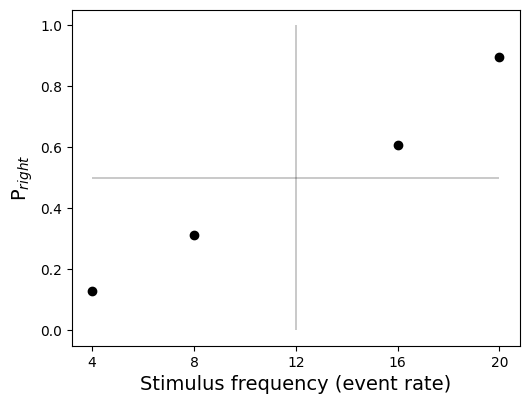

In [42]:
sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
sel = sel.reset_index(drop=True)
responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   

rate_list = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

frequencies = np.array(list(freq_presented))  # the stimulus intensity values
p_right = np.zeros_like(frequencies,dtype=float)     # pre-allocate the array (fill with zeros when you know the size)
# note that p_left is cast to float so it can take fractional numbers
# this is the part where we estimate the probability of left lick
for i,frequency in enumerate(frequencies):
    p_right[i] = np.sum(responded_right[rate_list == frequency])/np.count_nonzero(rate_list == frequency)

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(frequencies,p_right,'ko')
ax.set_xticks([4, 8, 12, 16, 20])

ax.vlines(12,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
ax.hlines(0.5,np.min(frequencies),np.max(frequencies),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

ax.set_ylabel('P$_{right}$',fontsize = 14)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimulus frequency (event rate)', fontsize = 14); # set the x-axis label

### Fit the psychometric curve to trial data

It is common to obtain a psychometric function so that we can extract parameters from the fit and compare subjects or conditions.

We will fit it with a cumulative gaussian, by minimizing the log likelihood error of all trials. 
A good course on this is here (where they use the weibull) http://courses.washington.edu/matlab1/Lesson_5.html#6

Note that fitting to the average points is not good, because all intensities count the same for the fit but there are some have different number of trials. The log likelihood tries to solve this. 

This time we will also compute the confidence intervals usign the Wilson binomial confidence interval.



Estimated parameters: alpha 12.32 beta 0.14 gamma 0.00 lambda 0.00


/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_82961/3647604078.py:51: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(func, x0, options = dict(maxiter = 500*len(x0),adaptive=True),


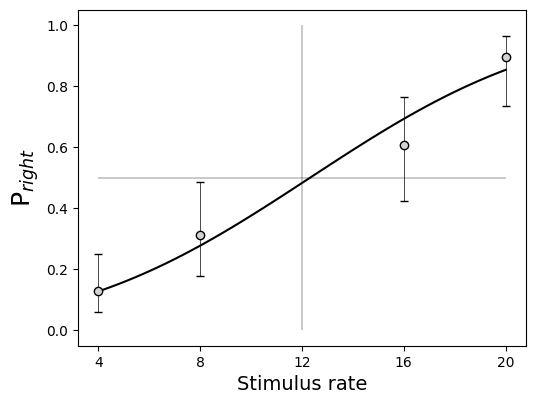

In [34]:
# first get the average points like above
frequencies = np.sort(np.array(list(freq_presented)).astype(float))
p_right = np.zeros_like(frequencies,dtype=float) 
ci_right = np.zeros((len(frequencies),2),dtype=float)

from statsmodels.stats.proportion import proportion_confint
for i,frequency in enumerate(frequencies):
    cnt = np.sum(responded_right[rate_list == frequency]) # number of times the subject licked left 
    nobs = np.count_nonzero(rate_list == frequency) # number of observations (ntrials)
    p_right[i] = cnt/nobs
    ci_right[i] = proportion_confint(cnt,nobs,method='wilson') # 95% confidence interval

def cumulative_gaussian(alpha,beta,gamma,lmbda, X):
    '''
    Evaluate the cumulative gaussian psychometric function.
       alpha is the bias (left or right)
       beta is the stepness
       gamma is the left handside offset
       lmbda is the right handside offset
      
    Adapted from the Palamedes toolbox 
    Joao Couto - Jan 2022    
    '''
        
    from scipy.special import erfc # import the complementary error function
    return  gamma + (1 - gamma - lmbda)*0.5*erfc(-beta*(X-alpha)/np.sqrt(2))+1e-9    

from scipy.optimize import minimize

def neg_log_likelihood_error(func, parameters, X, Y):
    '''
    Compute the log likelihood

    'func' is the (psychometric) function 
    'parameters' are the input parameters to 'func'
    'Y' is the binary response (correct = 1; incorrect=0)
    '''

    pX = func(*parameters, X)*0.99 + 0.005  # the predicted performance for X from the PMF
    # epsilon to prevent error in log(0)
    val = np.nansum(Y*np.log(pX) + (1-Y)*np.log(1-pX))
    return -1*val
#
rate_list = np.array(rate_list)
func = lambda pars: neg_log_likelihood_error(cumulative_gaussian, pars, rate_list.astype(float),responded_right.astype(float))
# x0 is the initial guess for the fit, it is an important parameter
x0 = [0.,0.1,p_right[0],1 - p_right[-1]]

bounds = [(frequencies[0],frequencies[-1]),(0.0001,10),(0,0.7),(0,0.7)]

res = minimize(func, x0, options = dict(maxiter = 500*len(x0),adaptive=True),
               bounds = bounds, method='Nelder-Mead') # method = 'L-BFGS-B',

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.vlines(12,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
ax.hlines(0.5,np.min(frequencies),np.max(frequencies),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance
ax.set_xticks([4, 8, 12, 16, 20])

# plot the fit
nx = np.linspace(np.min(frequencies),np.max(frequencies),100)
ax.plot(nx,cumulative_gaussian(*res.x,nx),'k')

# plot the observed data and confidence intervals
for i,e in zip(frequencies,ci_right):  # plot the confidence intervals
    ax.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
    
ax.plot(frequencies,p_right,'ko',markerfacecolor = 'lightgray',markersize = 6)

ax.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimulus rate', fontsize = 14); # set the x-axis label
print('Estimated parameters: alpha {0:2.2f} beta {1:2.2f} gamma {2:2.2f} lambda {3:2.2f}'.format(*res.x))


In [ ]:
#print(np.sqrt(np.diag(res.hess_inv.todense()))) # The sqrt of the diagonal of the cov mat are the parameter errors? 